In [162]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
import rasterio
from rasterio.plot import show
from PIL import Image
import os
import skimage as ski
from skimage import io
io.use_plugin('pil')
from skimage.metrics import structural_similarity as ssim

In [51]:
def convert_to_grayscale(image):
    img_final = np.zeros((1,image.shape[1],image.shape[2]))
    img_final[0,:,:] = image[0,:,:]+image[1,:,:]+image[2,:,:]
    return img_final

In [52]:

def normalize_images(images):
    min_value = np.min(images)
    max_value = np.max(images)
    normalized_images = (images - min_value) / (max_value - min_value)
    return normalized_images


In [53]:
def make_it_gray(img):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if(img[i][j]==0):
                img[i][j]=0.5
            else:
                img[i][j]=0
    return img

In [54]:
def subsample(img, k):
    lst = []
    for i in range(0,img.shape[0]):
        x = img[i][::k, ::k]
        lst.append(x.T)
    return np.array(lst)

In [124]:
dataset = []


folder_path = "/home/rounak/Desktop/LabeledData"
image_files = [file for file in os.listdir(folder_path) if file.endswith(('.tiff'))]
k=0
image_files.sort()
for j in range(30):
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        if(k%100==0):
            print(k)
        k+=1
        img_push = np.zeros((323,323,3))
        img = io.imread(image_path, plugin='pil')
        img = np.array(img)
        img_push[:,:,0] = normalize_images(img[:,:,0])*0.6
        img_push[:,:,1] = 2*normalize_images(img[:,:,2])+0.6*normalize_images(img[:,:,0])
        img_push[:,:,2] = normalize_images(img[:,:,0])*0.6
        img_push = np.array(img_push)
        image_array = img_push.T
        img = normalize_images(img)
        dataset.append((torch.from_numpy(np.expand_dims(np.float32(img[:,:,0]),axis=0)),0))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600


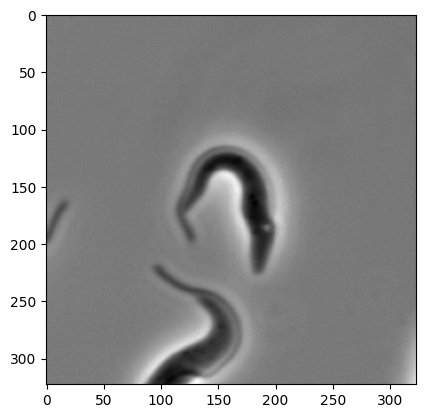

In [61]:
path = "/home/rounak/Desktop/LabeledData/Tb927.1.4340_c_0_24.tiff"
img = io.imread(image_path, plugin='pil')
img = np.array(img)
plt.imshow(img[:,:,0],cmap="gray")

In [7]:
def stochastic_mixer(img1, img2, t, k):
    noise_1 = torch.randn_like(img1)
    noise_2 = torch.randn_like(img2)
    img1_encode = perturb_input(img1, t, noise_1)
    img2_encode = perturb_input(img2, t, noise_2)
    img1_vec = np.reshape(img1, (-1, 1))
    img2_vec = np.reshape(img2, (-1, 1))
    theta = np.arccos(np.matmul(img1_vec.T, img2_vec))/np.linalg.norm(img1_vec)*np.linalg.norm(img2_vec)
    img_inter_ddim = np.sin(k*theta)/np.sin(theta)*img1_encode + np.sin((1-k)*theta)/np.sin(theta)*img2_encode
    return img_inter_ddim       # create other dot products
    

def interpolator(img1, img2, t_1 = timesteps*0.7, k=0.5):
    sample = stochastic_mixer(img1, img2, t, k)
    t = torch.tensor(t_1 / timesteps).to(device)
    z = torch.randn_like(sample) if i > 1 else 0
    eps = nn_model(samples, t)
    sample = denoise_add_noise(sample, t_1, eps, z)
    return sample

def image_value(img):
    value=0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            value+=img[i][j]
    return value


NameError: name 'timesteps' is not defined

In [ ]:
import keras
from keras import layers
import tensorflow as tf

input_img = keras.Input(shape=(320, 320, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train_1,
                epochs=50,
                batch_size=128,
                shuffle=True)

In [125]:
dataset[0][0].shape

torch.Size([1, 323, 323])

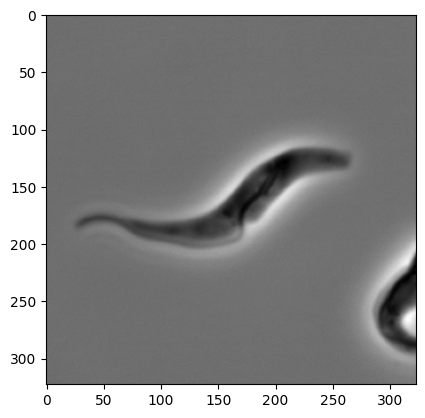

In [126]:
plt.imshow(dataset[40][0].T, cmap="gray")

In [127]:
dataset[0][0]

tensor([[[0.0029, 0.0029, 0.0024,  ..., 0.5571, 0.5462, 0.5485],
         [0.0018, 0.0024, 0.0032,  ..., 0.5491, 0.5539, 0.5472],
         [0.0026, 0.0028, 0.0026,  ..., 0.5461, 0.5454, 0.5462],
         ...,
         [0.5294, 0.5327, 0.5315,  ..., 0.5211, 0.5169, 0.5273],
         [0.5290, 0.5222, 0.5387,  ..., 0.5240, 0.5261, 0.5177],
         [0.5298, 0.5402, 0.5277,  ..., 0.5222, 0.5213, 0.5176]]])

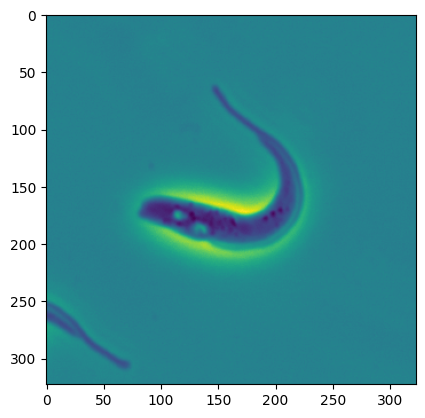

In [9]:
i=np.random.randint(300)
plt.imshow(dataset[i][0].T)

In [128]:
dataset_compressed = []

for i in range(5610):
    dataset_compressed.append(np.float32(np.array(dataset[i][0].T)))
    if(i%100==0):
        print(i)
dataset_compressed = np.array(dataset_compressed)

dataset_compressed = subsample(dataset_compressed, 4)

dataset_compressed = np.array(dataset_compressed)

dataset_compressed.shape

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600


(5610, 1, 81, 81)

In [129]:
dataset_compressed = normalize_images(np.float32(np.array(dataset_compressed)))
dataset_compressed.shape

(5610, 1, 81, 81)

In [130]:
dataset_final_1 = []
for i in range(5610):
    img_arr = dataset_compressed[i]
    img_arr = img_arr[:, :80, :80]
    dataset_final_1.append((torch.from_numpy(img_arr),0))


In [131]:
np.random.shuffle(dataset_final_1)

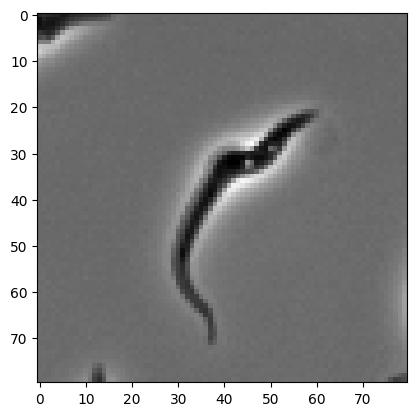

In [132]:
plt.imshow(dataset_final_1[176][0].T, cmap="gray")

In [133]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, is_res: bool = False) -> None:
        super().__init__()
        self.same_channels = in_channels == out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels), 
            nn.GELU(), 
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            if self.same_channels:
                out = x + x2
            else:  
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

In [134]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels), 
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        return self.model(torch.cat((x, skip), 1))


In [135]:

class EmbedFC(nn.Module):
    def __init__(self, input_dim , emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim).to(device)
        return self.model(x)

In [136]:
class TimeSiren(nn.Module):
    def __init__(self, emb_dim):
        super(TimeSiren, self).__init__()

        self.lin1 = nn.Linear(1, emb_dim, bias=False)
        self.lin2 = nn.Linear(emb_dim, emb_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(-1, 1).to(device)
        x = torch.sin(self.lin1(x))
        x = self.lin2(x)
        return x

In [137]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10):
        super(ContextUnet, self).__init__()
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)
        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)
        self.down3 = UnetDown(2 * n_feat, 4 * n_feat)
        self.to_vec = nn.Sequential(nn.AvgPool2d((2)), nn.GELU())
        self.timeembed1 = EmbedFC(1, 4*n_feat)
        self.timeembed2 = EmbedFC(1, 2*n_feat)
        self.timeembed3 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 4*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed3 = EmbedFC(n_cfeat, 1*n_feat)
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(4 * n_feat, 4 * n_feat, 2, 2),
            nn.GroupNorm(8, 4 * n_feat),
            nn.ReLU(),
        )
        self.up1 = UnetUp(8 * n_feat, 2 * n_feat)
        self.up2 = UnetUp(4 * n_feat, n_feat)
        self.up3 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, t, c=None):
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2)
        hiddenvec = self.to_vec(down3)
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 4, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 4, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat * 2, 1, 1)
        cemb3 = self.contextembed3(c).view(-1, self.n_feat, 1, 1)
        temb3 = self.timeembed3(t).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down3)
        up3 = self.up2(cemb2*up2 + temb2, down2)
        up4 = self.up3(cemb3*up3 + temb3, down1)
        out = self.out(torch.cat((up4, x), 1))
        return out


In [138]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

1.4271119360000002

In [139]:
timesteps = 300
beta1 = 1e-4
beta2 = 0.02


device="cuda" if torch.cuda.is_available() else "cpu"
n_feat = 256 
n_cfeat = 10 
height = 80
save_dir = './weight_tryptag_nochange_2/'

batch_size = 50
n_epoch = 2000
lrate=1e-5

In [140]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

1.4271119360000002

In [141]:
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] = 1
b_t = b_t.to(device)
a_t  = a_t.to(b_t)
ab_t = ab_t.to(a_t)

In [142]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

1.4271119360000002

In [143]:
@torch.no_grad()
def sample_ddpm_context(n_sample, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 1, height, height).to(device)  

    # array to keep track of generated steps for plotting
    intermediate = [] 
    for i in range(timesteps, 0, -1):
        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t)    # predict noise e_(x_t,t, ctx)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [144]:
nn_model = ContextUnet(in_channels=1, n_feat=n_feat, n_cfeat=n_cfeat).to(device)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

In [145]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

1.6187212800000002

In [146]:
dataloader = DataLoader(dataset_final_1, batch_size=batch_size, shuffle=True)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

In [147]:
dataset[0][0].shape

torch.Size([1, 323, 323])

In [148]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

1.6187212800000002

In [149]:
# helper function: perturbs an image to a specified noise level
def perturb_input(x, t, noise, device=device):
    final = ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise
    final = final.to(device)
    return final

In [150]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [151]:
# define sampling function for DDIM   
# removes the noise using ddim
def denoise_ddim(x, t, t_prev, pred_noise):
    ab = ab_t[t]
    ab_prev = ab_t[t_prev]
    
    x0_pred = ab_prev.sqrt() / ab.sqrt() * (x - (1 - ab).sqrt() * pred_noise)
    dir_xt = (1 - ab_prev).sqrt() * pred_noise

    return x0_pred + dir_xt

In [152]:
# fast sampling algorithm with context
@torch.no_grad()
def sample_ddim_context(n_sample, n=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 1, height, height).to(device)  

    # array to keep track of generated steps for plotting
    intermediate = [] 
    step_size = timesteps // n
    for i in range(timesteps, 0, -step_size):
        
        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        eps = nn_model(samples, t)    # predict noise e_(x_t,t)
        samples = denoise_ddim(samples, i, i - step_size, eps)
        intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [153]:
def make_encoding(x, n_samples=batch_size, n_classes=n_cfeat):
    encode = [
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
    ]
    final = np.zeros((n_samples, n_classes))
    for i in range(n_samples):
        final[i] = encode[x[i].int()]
    final = torch.tensor(final).float().to(device)
    return final

In [154]:
loss_train  = []

In [155]:
def show_images(imgs, nrow=2):
    _, axs = plt.subplots(nrow, imgs.shape[0] // nrow, figsize=(4,2 ))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img, cmap='gray')
    plt.show()

In [156]:
torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9

1.6187212800000002

In [157]:
checkpoint = torch.load(f"{save_dir}nn_model_best.pth", map_location = device)
epoch = checkpoint['epoch']
optim.load_state_dict(checkpoint['optimizer_state_dict'])
nn_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [158]:
epoch = 0
loss_vals = []

In [159]:
import os
nn_model.train()
loss_min = 1e10

for ep in range(epoch, n_epoch):
    print("allocated mem -", torch.cuda.memory_allocated(torch.device("cuda")) * 1e-9)
    print("epoch number: ", ep)
    optim.param_groups[0]['lr'] = lrate/10*(1-0.2*ep/n_epoch)
    pbar = tqdm(dataloader, mininterval = 2)
    #print(pbar)
    #break
    #k=0
    loss_val = 0
    
    for x,_ in pbar:
        optim.zero_grad()
        x=x.to(device)
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],))
        x_pert = perturb_input(x, t, noise).to(device)
        pred_noise = nn_model(x_pert, t/timesteps)
        loss = F.mse_loss(pred_noise, noise)
        #loss_values_1.append(loss.item())
        loss_val+=loss
        loss.backward()
        optim.step()
    if(ep%10==0):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save({
            'epoch': ep,
            'model_state_dict': nn_model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': loss_val
            }, str(save_dir+f"nn_model{ep}.pth"))
        print("Saved model at " + str(save_dir+f"nn_model{ep}.pth"))
    if(loss_min>loss_val):
        loss_min = loss_val
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save({
            'epoch': ep,
            'model_state_dict': nn_model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': loss_val
            }, str(save_dir+f"nn_model_best.pth"))
        print("Saved model at " + str(save_dir+f"nn_model_best.pth"))
    elif(ep%50==0 or ep==n_epoch-1):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save({
            'epoch': ep,
            'model_state_dict': nn_model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': loss_val
            }, str(save_dir+f"nn_model{ep}.pth"))
        print("Saved model at " + str(save_dir+f"nn_model{ep}.pth"))
    print(loss_val)
    loss_vals.append(loss_val)

allocated mem - 1.942144
epoch number:  0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:06<00:00,  1.71it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model0.pth
Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(9.9991, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.128655872
epoch number:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:07<00:00,  1.67it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(9.7287, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1291192320000003
epoch number:  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:04<00:00,  1.75it/s]


tensor(9.8967, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.129582592
epoch number:  3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(9.5862, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.130045952
epoch number:  4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(9.4769, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.130509312
epoch number:  5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.5814, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.130972672
epoch number:  6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.8608, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1314360320000003
epoch number:  7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.5989, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1318993920000002
epoch number:  8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.5196, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.132362752
epoch number:  9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.9870, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.132826112
epoch number:  10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:04<00:00,  1.76it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model10.pth
Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(9.2742, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.133289472
epoch number:  11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.7665, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1337528320000003
epoch number:  12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.4399, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1342161920000002
epoch number:  13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.4870, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.134679552
epoch number:  14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(9.2174, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.135142912
epoch number:  15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.6921, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.135606272
epoch number:  16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.2389, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1360696320000003
epoch number:  17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.2316, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1365329920000002
epoch number:  18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.3664, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.136996352
epoch number:  19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(9.0281, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.137459712
epoch number:  20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model20.pth
tensor(9.4228, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.137923072
epoch number:  21


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.6978, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1383864320000003
epoch number:  22


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.3949, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1388497920000002
epoch number:  23


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(8.7429, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.139313152
epoch number:  24


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.8155, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.139776512
epoch number:  25


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.4030, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.140239872
epoch number:  26


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.5779, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1407032320000003
epoch number:  27


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.9646, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1411665920000003
epoch number:  28


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.4801, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.141629952
epoch number:  29


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.2480, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.142093312
epoch number:  30


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model30.pth
tensor(8.9211, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.142556672
epoch number:  31


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.9469, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1430200320000004
epoch number:  32


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.9040, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1434833920000003
epoch number:  33


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.9872, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.143946752
epoch number:  34


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.1748, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.144410112
epoch number:  35


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.5189, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.144873472
epoch number:  36


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.1720, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.145336832
epoch number:  37


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.8252, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1458001920000003
epoch number:  38


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(8.7120, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.146263552
epoch number:  39


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.8232, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.146726912
epoch number:  40


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model40.pth
Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(8.5119, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.147190272
epoch number:  41


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.5954, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.147653632
epoch number:  42


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.5237, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1481169920000003
epoch number:  43


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.0038, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.148580352
epoch number:  44


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.0456, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.149043712
epoch number:  45


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.0501, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.149507072
epoch number:  46


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(8.2954, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.149970432
epoch number:  47


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(9.2700, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1504337920000003
epoch number:  48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.6369, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.150897152
epoch number:  49


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.8522, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.151360512
epoch number:  50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model50.pth
Saved model at ./weight_tryptag_nochange_2/nn_model50.pth
tensor(8.4692, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.151823872
epoch number:  51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.4651, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.152287232
epoch number:  52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.6060, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1527505920000003
epoch number:  53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(7.9563, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.153213952
epoch number:  54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.0616, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.153677312
epoch number:  55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.8495, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.154140672
epoch number:  56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(7.7736, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.154604032
epoch number:  57


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.8065, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1550673920000003
epoch number:  58


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.5771, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.155530752
epoch number:  59


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.4397, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.155994112
epoch number:  60


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model60.pth
tensor(8.9788, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.156457472
epoch number:  61


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.6024, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.156920832
epoch number:  62


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.1135, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1573841920000003
epoch number:  63


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.5246, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1578475520000002
epoch number:  64


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.5819, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.158310912
epoch number:  65


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.1397, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.158774272
epoch number:  66


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.6128, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.159237632
epoch number:  67


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.0324, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1597009920000003
epoch number:  68


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.2095, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1601643520000002
epoch number:  69


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.8962, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.160627712
epoch number:  70


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model70.pth
tensor(7.9989, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.161091072
epoch number:  71


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(7.7473, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.161554432
epoch number:  72


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.6089, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1620177920000003
epoch number:  73


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.7903, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1624811520000002
epoch number:  74


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.8499, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.162944512
epoch number:  75


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.8746, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.163407872
epoch number:  76


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.0566, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.163871232
epoch number:  77


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.1044, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1643345920000003
epoch number:  78


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.5708, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1647979520000002
epoch number:  79


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.2135, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.165261312
epoch number:  80


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model80.pth
tensor(8.2856, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.165724672
epoch number:  81


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.9331, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.166188032
epoch number:  82


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.7737, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1666513920000003
epoch number:  83


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.0709, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1671147520000003
epoch number:  84


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.3835, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.167578112
epoch number:  85


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.3500, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.168041472
epoch number:  86


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.9652, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.168504832
epoch number:  87


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.0546, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1689681920000004
epoch number:  88


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.5880, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1694315520000003
epoch number:  89


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.5988, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.169894912
epoch number:  90


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model90.pth
tensor(8.2533, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.170358272
epoch number:  91


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.4632, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.170821632
epoch number:  92


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.4222, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.171284992
epoch number:  93


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.0517, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1717483520000003
epoch number:  94


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.7769, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.172211712
epoch number:  95


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.2747, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.172675072
epoch number:  96


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.9531, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.173138432
epoch number:  97


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(7.6934, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.173601792
epoch number:  98


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(7.4469, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1740651520000003
epoch number:  99


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.1555, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.174528512
epoch number:  100


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model100.pth
Saved model at ./weight_tryptag_nochange_2/nn_model100.pth
tensor(8.0448, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.174991872
epoch number:  101


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.9470, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.175455232
epoch number:  102


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.2058, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.175918592
epoch number:  103


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.7009, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1763819520000003
epoch number:  104


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.6243, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.176845312
epoch number:  105


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.0450, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.177308672
epoch number:  106


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.9893, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.177772032
epoch number:  107


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.9541, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.178235392
epoch number:  108


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.7788, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1786987520000003
epoch number:  109


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.7601, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.179162112
epoch number:  110


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model110.pth
tensor(7.6070, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.179625472
epoch number:  111


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.7858, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.180088832
epoch number:  112


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.7652, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.180552192
epoch number:  113


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.7837, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1810155520000003
epoch number:  114


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.6703, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.181478912
epoch number:  115


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.9398, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.181942272
epoch number:  116


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.8055, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.182405632
epoch number:  117


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.9167, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.182868992
epoch number:  118


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(7.3638, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1833323520000003
epoch number:  119


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.7692, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.183795712
epoch number:  120


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model120.pth
tensor(7.4319, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.184259072
epoch number:  121


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.1030, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.184722432
epoch number:  122


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.6658, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.185185792
epoch number:  123


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.7647, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1856491520000003
epoch number:  124


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.5371, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1861125120000002
epoch number:  125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.0380, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.186575872
epoch number:  126


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.8374, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.187039232
epoch number:  127


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.7777, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.187502592
epoch number:  128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.8962, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1879659520000003
epoch number:  129


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.6116, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1884293120000002
epoch number:  130


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model130.pth
tensor(7.7889, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.188892672
epoch number:  131


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.5665, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.189356032
epoch number:  132


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.4259, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.189819392
epoch number:  133


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.4175, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1902827520000003
epoch number:  134


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.5009, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.1907461120000002
epoch number:  135


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.4788, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 2.191209472
epoch number:  136


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:04<00:00,  1.76it/s]


tensor(7.6180, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4266240000000001
epoch number:  137


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.5234, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.42708736
epoch number:  138


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.6588, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4275507200000002
epoch number:  139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.5293, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.42801408
epoch number:  140


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model140.pth
Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(7.3399, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.42847744
epoch number:  141


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.3501, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4289408000000001
epoch number:  142


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.3611, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.42940416
epoch number:  143


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.4444, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4298675200000002
epoch number:  144


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.7926, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.43033088
epoch number:  145


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.7170, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.43079424
epoch number:  146


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.4540, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4312576000000001
epoch number:  147


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(7.3323, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.43172096
epoch number:  148


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.4808, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4321843200000002
epoch number:  149


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(8.2300, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.43264768
epoch number:  150


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model150.pth
Saved model at ./weight_tryptag_nochange_2/nn_model150.pth
tensor(7.5263, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.43311104
epoch number:  151


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.5329, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4335744000000001
epoch number:  152


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.5989, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.43403776
epoch number:  153


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.6650, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4345011200000002
epoch number:  154


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.4499, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.43496448
epoch number:  155


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(7.2164, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.43542784
epoch number:  156


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.2630, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4358912000000001
epoch number:  157


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.6519, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.43635456
epoch number:  158


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(6.9342, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4368179200000002
epoch number:  159


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.4019, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.43728128
epoch number:  160


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model160.pth
tensor(7.3177, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.43774464
epoch number:  161


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.1304, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4382080000000002
epoch number:  162


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.8070, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.43867136
epoch number:  163


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.4728, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4391347200000002
epoch number:  164


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.0996, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4395980800000001
epoch number:  165


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(6.8503, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.44006144
epoch number:  166


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.5248, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4405248000000002
epoch number:  167


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.3500, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.44098816
epoch number:  168


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.1264, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.44145152
epoch number:  169


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.1880, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4419148800000001
epoch number:  170


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model170.pth
tensor(7.5779, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.44237824
epoch number:  171


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.3202, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4428416000000002
epoch number:  172


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.7559, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.44330496
epoch number:  173


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.5414, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.44376832
epoch number:  174


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.6553, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4442316800000001
epoch number:  175


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.3796, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.44469504
epoch number:  176


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.5030, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4451584000000002
epoch number:  177


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.3880, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.44562176
epoch number:  178


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.3281, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.44608512
epoch number:  179


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.1036, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4465484800000001
epoch number:  180


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model180.pth
tensor(7.3122, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.44701184
epoch number:  181


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.6623, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4474752000000002
epoch number:  182


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.8905, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.44793856
epoch number:  183


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.4759, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.44840192
epoch number:  184


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.8992, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4488652800000001
epoch number:  185


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.6470, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.44932864
epoch number:  186


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.1943, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4497920000000002
epoch number:  187


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.8752, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.45025536
epoch number:  188


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.1930, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.45071872
epoch number:  189


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.8169, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4511820800000002
epoch number:  190


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model190.pth
tensor(7.1430, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.45164544
epoch number:  191


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.2559, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4521088000000002
epoch number:  192


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.2139, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4525721600000001
epoch number:  193


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.3084, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.45303552
epoch number:  194


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.1491, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4534988800000002
epoch number:  195


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.9690, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.45396224
epoch number:  196


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.1714, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4544256
epoch number:  197


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.3617, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4548889600000001
epoch number:  198


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.2938, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.45535232
epoch number:  199


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.9106, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4558156800000002
epoch number:  200


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model200.pth
Saved model at ./weight_tryptag_nochange_2/nn_model200.pth
tensor(7.3614, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.45627904
epoch number:  201


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.0230, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4567424
epoch number:  202


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.4581, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4572057600000001
epoch number:  203


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(6.7554, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.45766912
epoch number:  204


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.5857, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4581324800000002
epoch number:  205


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.5632, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.45859584
epoch number:  206


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.4544, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4590592
epoch number:  207


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:04<00:00,  1.77it/s]


tensor(7.4092, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4595225600000001
epoch number:  208


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(6.5596, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.45998592
epoch number:  209


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.9418, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4604492800000002
epoch number:  210


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model210.pth
tensor(7.0521, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.46091264
epoch number:  211


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.0018, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.461376
epoch number:  212


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.8541, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4618393600000001
epoch number:  213


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.0435, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.46230272
epoch number:  214


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.1632, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4627660800000002
epoch number:  215


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.3607, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.46322944
epoch number:  216


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.0225, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4636928
epoch number:  217


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.3635, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4641561600000002
epoch number:  218


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.3166, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.46461952
epoch number:  219


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.2098, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4650828800000002
epoch number:  220


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model220.pth
tensor(7.2068, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4655462400000001
epoch number:  221


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.6847, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4660096
epoch number:  222


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.3116, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4664729600000002
epoch number:  223


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.9404, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.46693632
epoch number:  224


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5782, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.46739968
epoch number:  225


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.6799, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4678630400000001
epoch number:  226


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.5439, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4683264
epoch number:  227


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.0634, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4687897600000002
epoch number:  228


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.3623, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.46925312
epoch number:  229


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.4805, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.46971648
epoch number:  230


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model230.pth
tensor(6.8340, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4701798400000001
epoch number:  231


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.9483, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4706432
epoch number:  232


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(6.5222, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4711065600000002
epoch number:  233


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.2796, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.47156992
epoch number:  234


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.9138, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.47203328
epoch number:  235


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(6.3388, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4724966400000001
epoch number:  236


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.1198, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.47296
epoch number:  237


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.9243, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4734233600000002
epoch number:  238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.9634, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.47388672
epoch number:  239


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:04<00:00,  1.77it/s]


tensor(6.7249, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.47435008
epoch number:  240


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model240.pth
tensor(7.0368, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4748134400000001
epoch number:  241


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.6190, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4752768
epoch number:  242


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.7480, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4757401600000002
epoch number:  243


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5774, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.47620352
epoch number:  244


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.8909, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.47666688
epoch number:  245


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5491, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4771302400000001
epoch number:  246


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.6669, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4775936
epoch number:  247


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.1854, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4780569600000002
epoch number:  248


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.8633, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.47852032
epoch number:  249


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.3859, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.47898368
epoch number:  250


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model250.pth
Saved model at ./weight_tryptag_nochange_2/nn_model250.pth
tensor(6.6654, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4794470400000002
epoch number:  251


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.0577, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4799104
epoch number:  252


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.9080, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.48037376
epoch number:  253


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5137, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4808371200000001
epoch number:  254


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.6816, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.48130048
epoch number:  255


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.0033, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4817638400000002
epoch number:  256


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.0534, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4822272
epoch number:  257


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.6385, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.48269056
epoch number:  258


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.9124, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4831539200000001
epoch number:  259


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.0819, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.48361728
epoch number:  260


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model260.pth
tensor(6.8609, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4840806400000002
epoch number:  261


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.3537, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.484544
epoch number:  262


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.4321, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.48500736
epoch number:  263


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.9163, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4854707200000001
epoch number:  264


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.8727, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.48593408
epoch number:  265


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.7348, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4863974400000002
epoch number:  266


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.4135, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4868608
epoch number:  267


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.0053, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.48732416
epoch number:  268


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.0569, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4877875200000001
epoch number:  269


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.2403, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.48825088
epoch number:  270


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model270.pth
tensor(6.9303, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4887142400000002
epoch number:  271


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.8754, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4891776
epoch number:  272


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.8718, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.48964096
epoch number:  273


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.1683, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4901043200000001
epoch number:  274


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.8272, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.49056768
epoch number:  275


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.6431, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4910310400000002
epoch number:  276


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.9551, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4914944
epoch number:  277


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.9977, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.49195776
epoch number:  278


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5887, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4924211200000002
epoch number:  279


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.4310, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.49288448
epoch number:  280


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model280.pth
tensor(6.6585, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4933478400000002
epoch number:  281


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.7721, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4938112000000001
epoch number:  282


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.6847, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.49427456
epoch number:  283


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.7508, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4947379200000002
epoch number:  284


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.6361, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.49520128
epoch number:  285


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5793, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.49566464
epoch number:  286


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.0238, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4961280000000001
epoch number:  287


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.1224, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.49659136
epoch number:  288


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.9295, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4970547200000002
epoch number:  289


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.6658, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.49751808
epoch number:  290


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model290.pth
tensor(6.4057, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.49798144
epoch number:  291


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.8500, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4984448000000001
epoch number:  292


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.0537, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.49890816
epoch number:  293


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.4248, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.4993715200000002
epoch number:  294


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.4884, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.49983488
epoch number:  295


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.2376, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.50029824
epoch number:  296


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5711, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5007616000000001
epoch number:  297


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.4689, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.50122496
epoch number:  298


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.4976, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5016883200000002
epoch number:  299


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.8384, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.50215168
epoch number:  300


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model300.pth
Saved model at ./weight_tryptag_nochange_2/nn_model300.pth
tensor(6.3541, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.50261504
epoch number:  301


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.7060, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5030784000000001
epoch number:  302


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.9549, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.50354176
epoch number:  303


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.4573, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5040051200000002
epoch number:  304


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.0919, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.50446848
epoch number:  305


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5531, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.50493184
epoch number:  306


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.6680, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5053952000000002
epoch number:  307


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.4443, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.50585856
epoch number:  308


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.7173, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5063219200000002
epoch number:  309


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.4167, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5067852800000001
epoch number:  310


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model310.pth
tensor(7.0340, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.50724864
epoch number:  311


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.4158, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5077120000000002
epoch number:  312


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.7944, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.50817536
epoch number:  313


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.1133, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.50863872
epoch number:  314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5318, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5091020800000001
epoch number:  315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(6.2273, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.50956544
epoch number:  316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.7361, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5100288000000002
epoch number:  317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.8328, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.51049216
epoch number:  318


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.1186, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.51095552
epoch number:  319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5841, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5114188800000001
epoch number:  320


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model320.pth
tensor(6.5054, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.51188224
epoch number:  321


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5718, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5123456000000002
epoch number:  322


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5706, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.51280896
epoch number:  323


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.0685, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.51327232
epoch number:  324


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.7466, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5137356800000001
epoch number:  325


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.9007, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.51419904
epoch number:  326


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.3637, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5146624000000002
epoch number:  327


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.6487, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.51512576
epoch number:  328


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.2413, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.51558912
epoch number:  329


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5931, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5160524800000001
epoch number:  330


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model330.pth
tensor(6.7745, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.51651584
epoch number:  331


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5547, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5169792000000002
epoch number:  332


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.4087, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.51744256
epoch number:  333


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5043, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.51790592
epoch number:  334


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.3477, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5183692800000002
epoch number:  335


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.8182, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.51883264
epoch number:  336


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.7289, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5192960000000002
epoch number:  337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.3884, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5197593600000001
epoch number:  338


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.9482, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.52022272
epoch number:  339


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5536, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5206860800000002
epoch number:  340


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model340.pth
tensor(6.2622, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.52114944
epoch number:  341


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.6928, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5216128
epoch number:  342


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.6463, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5220761600000001
epoch number:  343


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(6.1966, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.52253952
epoch number:  344


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.4985, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5230028800000002
epoch number:  345


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(6.1339, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.52346624
epoch number:  346


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.6369, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5239296
epoch number:  347


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.6329, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5243929600000001
epoch number:  348


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5923, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.52485632
epoch number:  349


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.7516, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5253196800000002
epoch number:  350


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model350.pth
Saved model at ./weight_tryptag_nochange_2/nn_model350.pth
tensor(6.7599, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.52578304
epoch number:  351


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(5.8988, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5262464
epoch number:  352


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.4639, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5267097600000001
epoch number:  353


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.9419, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.52717312
epoch number:  354


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.7218, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5276364800000002
epoch number:  355


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.8706, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.52809984
epoch number:  356


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5654, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5285632
epoch number:  357


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.1574, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5290265600000001
epoch number:  358


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.7954, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.52948992
epoch number:  359


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model_best.pth
tensor(5.5579, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5299532800000002
epoch number:  360


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model360.pth
tensor(6.5327, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.53041664
epoch number:  361


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.4827, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.53088
epoch number:  362


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.2057, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5313433600000002
epoch number:  363


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(5.7021, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.53180672
epoch number:  364


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.1645, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5322700800000002
epoch number:  365


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.3556, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5327334400000001
epoch number:  366


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.2348, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5331968
epoch number:  367


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.4570, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5336601600000002
epoch number:  368


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(7.0322, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.53412352
epoch number:  369


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.3958, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.53458688
epoch number:  370


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model370.pth
tensor(6.6320, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5350502400000001
epoch number:  371


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5973, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5355136
epoch number:  372


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.4496, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5359769600000002
epoch number:  373


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.4140, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.53644032
epoch number:  374


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.6003, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.53690368
epoch number:  375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.3484, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5373670400000001
epoch number:  376


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.3568, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5378304
epoch number:  377


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.2686, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5382937600000002
epoch number:  378


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.4132, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.53875712
epoch number:  379


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.4344, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.53922048
epoch number:  380


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model380.pth
tensor(6.2948, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5396838400000001
epoch number:  381


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5310, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5401472
epoch number:  382


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.2674, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5406105600000002
epoch number:  383


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.7485, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.54107392
epoch number:  384


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.2501, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.54153728
epoch number:  385


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.7069, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5420006400000001
epoch number:  386


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.4942, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.542464
epoch number:  387


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.2010, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5429273600000002
epoch number:  388


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5700, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.54339072
epoch number:  389


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.2503, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.54385408
epoch number:  390


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model390.pth
tensor(6.2120, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5443174400000002
epoch number:  391


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.7028, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5447808
epoch number:  392


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.2921, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5452441600000002
epoch number:  393


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.1039, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5457075200000001
epoch number:  394


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.7568, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.54617088
epoch number:  395


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.4595, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5466342400000002
epoch number:  396


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.3323, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5470976
epoch number:  397


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.3529, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.54756096
epoch number:  398


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.3868, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5480243200000001
epoch number:  399


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5491, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.54848768
epoch number:  400


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model400.pth
Saved model at ./weight_tryptag_nochange_2/nn_model400.pth
tensor(6.5983, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5489510400000002
epoch number:  401


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.3341, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5494144
epoch number:  402


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.1143, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.54987776
epoch number:  403


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.3705, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5503411200000001
epoch number:  404


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5354, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.55080448
epoch number:  405


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.3482, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5512678400000002
epoch number:  406


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.2944, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5517312
epoch number:  407


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5180, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.55219456
epoch number:  408


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.0489, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5526579200000001
epoch number:  409


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.3017, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.55312128
epoch number:  410


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model410.pth
tensor(6.6865, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5535846400000002
epoch number:  411


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.2487, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.554048
epoch number:  412


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.4873, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.55451136
epoch number:  413


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.4397, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5549747200000001
epoch number:  414


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.1415, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.55543808
epoch number:  415


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.1809, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5559014400000002
epoch number:  416


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.7514, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5563648
epoch number:  417


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.3319, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.55682816
epoch number:  418


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.5113, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5572915200000002
epoch number:  419


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.3351, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.55775488
epoch number:  420


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


Saved model at ./weight_tryptag_nochange_2/nn_model420.pth
tensor(5.7440, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5582182400000002
epoch number:  421


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.4536, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.5586816000000001
epoch number:  422


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [01:03<00:00,  1.77it/s]


tensor(6.0340, device='cuda:0', grad_fn=<AddBackward0>)
allocated mem - 1.55914496
epoch number:  423


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 74/113 [00:43<00:22,  1.70it/s]


KeyboardInterrupt: 

In [ ]:
loss_values_1 = torch.tensor(loss_values_1).cpu()
plt.plot(np.array(loss_values_1))
loss_values_1 = loss_values_1.tolist()

In [ ]:
loss_values_1 = np.asarray(loss_values_1)
sum1=0
loss_values_epoch=[]
for i in range(1, loss_values_1.shape[0]):
    sum1+=loss_values_1[i]
    if(i%500==0):
        loss_values_epoch.append(sum1)
        sum1=0
loss_values_epoch = np.asarray(loss_values_epoch)
plt.plot(loss_values_epoch)

In [ ]:
loss_values_1.shape

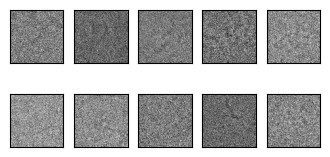

In [161]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddpm_context(10)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddim_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddim_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
import os
nn_model.train()
guide_w = 0.3
loss_values_2=[]
for ep in range(n_epoch):
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)
    pbar = tqdm(dataloader, mininterval = 2)
    for x, c in pbar:
        optim.zero_grad()
        x=x.to(device)
        c=c.to(device)
        c=make_encoding(c)
    #print(c.shape)
        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
        
    #print(c.shape)
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],))
        x_pert = perturb_input(x, t, noise).to(device)
        pred_noise_2 = nn_model(x_pert, t/timesteps, c=None)
        pred_noise_1 = nn_model(x_pert, t/timesteps, c)
        pred_noise_final = eps = (1+guide_w)*pred_noise_1 - guide_w*pred_noise_2
        loss = F.mse_loss(pred_noise_final, noise)
        loss_values_2.append(loss)
        loss.backward()
        optim.step()
    

In [ ]:
loss_values_2 = torch.tensor(loss_values_2).cpu()
plt.plot(np.array(loss_values_2)

In [ ]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddim_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddim_context(ctx.shape[0], ctx)
show_images(samples)

In [ ]:
# mix of defined context
ctx = torch.tensor([
    [1,0,0,0,0,0,0,0,0,0],
    [0.9,0.1,0,0,0,0,0,0,0,0],
    [0.8,0.2,0,0,0,0,0,0,0,0],
    [0.7,0.3,0,0,0,0,0,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0],
    [0.5,0.5,0,0,0,0,0,0,0,0],
    [0.4,0.6,0,0,0,0,0,0,0,0],
    [0.3,0.7,0,0,0,0,0,0,0,0],
    [0.2,0.8,0,0,0,0,0,0,0,0],
    [0.1,0.9,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
]).float().to(device)

samples, _ = sample_ddim_context(ctx.shape[0], None)
show_images(samples)

In [ ]:
# visualize samples with randomly selected context
plt.clf()
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0,0,0,0,0,0],  
    [0,1,0,0,0,0,0,0,0,0],    
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
#animation_ddpm_context = plot_sample(intermediate,32,4,save_dir, "ani_run", None, save=False)
#HTML(animation_ddpm_context.to_jshtml())